# Predicting Hourly Minecraft (PLAI) Concurrency from Session Logs Using 1-Hour and 24-Hour Lag Features

## 1 Introduction

### 1.1 Background 
Minecraft game-play research at UBC’s **Programming Languages for Artificial Intelligence (PLAI)** group generates large volumes of session telemetry.  
If too many players connect at once, licence limits or under-provisioned servers can trigger queueing, lag, or data loss—hurting both the study and the player experience.  
Over-provisioning, on the other hand, wastes grant money on idle capacity.  
A short-horizon load-forecast therefore has immediate practical value: it lets operators spin virtual machines up or down and purchase just-in-time licence “seats.”

### 1.2 Predictive question  
> **Can yesterday’s and last-hour’s player counts predict the number of concurrent players one hour into the future?**

* **Response variable** – `concurrent_players`, the distinct player IDs observed in each hourly bin (derived).  
* **Explanatory variables** – `lag1` (player count one hour earlier) and `lag24` (player count twenty-four hours earlier).

### 1.3 Raw data & preprocessing  
| Column in `sessions.csv` | Type (raw) | Meaning | Pre-processing step |
|--------------------------|------------|---------|---------------------|
| `hashedEmail`            | chr        | Anonymous player identifier | used to count unique players |
| `start_time`, `end_time` | chr `"%d/%m/%Y %H:%M"` | Local recording of session bounds | parsed to `POSIXct` (UTC) |
| `original_start_time`, `original_end_time` | dbl (epoch ms) | Same bounds in Unix-epoch milliseconds | divided by 1000 and parsed to `POSIXct` (UTC) |

* **Size & span:** The file contains **1,533** session records from **2024-04-06** to **2024-09-26**—roughly five months—and represents **125** unique players.
* **What each row shows:** Each row represents a single gameplay session, with a login and logout time.  
* **How we got hourly data:** To analyze patterns by the hour, we broke each session into all the hours it spans and counted how many unique players were active in each.  
* **Why two time formats?** One set of timestamps is easy to read, while the other keeps precise computer timing in case formatting changes.  
* **Cleaning:** We removed a small number of sessions with missing or invalid times (less than 0.1%).  
* **Gaps in time:** Even hours with no players are kept and marked as zero so we can treat the data as a regular time series.

### 1.4 Method and framework
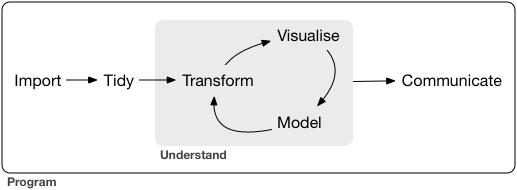

**Will use this framework from R for Data science (Grolemund, n.d.)**

In [235]:
# Adjust column name if cleaned
n_rows <- nrow(sessions)
n_players <- n_distinct(sessions$hashed_email)

start_times <- as.POSIXct(sessions$start_time, format = "%d/%m/%Y %H:%M", tz = "UTC")
end_times   <- as.POSIXct(sessions$end_time,   format = "%d/%m/%Y %H:%M", tz = "UTC")

date_span <- range(start_times, na.rm = TRUE)

cat("Total number of session records:", n_rows, "\n")
cat("Number of unique players:", n_players, "\n")
cat("Data spans from", format(date_span[1], "%Y-%m-%d"), "to", format(date_span[2], "%Y-%m-%d"), "\n")

Total number of session records: 1533 
Number of unique players: 125 
Data spans from 2024-04-06 to 2024-09-26 


## 2. Wrangle

Before we begin analyzing the data, we need to first **locate** and **structure** it for further processing, as outlined in *R for Data Science* (Grolemund, n.d.).

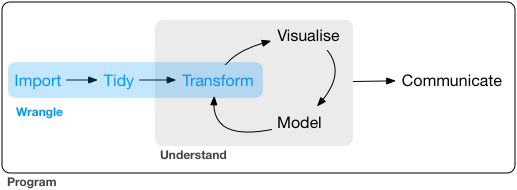

In particular, we used the **`lubridate`** package to handle date-time parsing and manipulation. The [Lubridate Cheatsheet](https://rstudio.github.io/cheatsheets/html/lubridate.html) (RStudio, n.d.) was especially helpful for converting raw timestamps into usable formats such as hours, days, and months.

These steps ensured that we could align player sessions accurately across hourly intervals and extract meaningful time-based features for modeling.

### 2.1 Load libraries & Seed

In [236]:
library(tidyverse)
library(lubridate)
library(patchwork)
library(slider)
set.seed(1)

### 2.2 Import Data

In [183]:
sessions <- read_csv("data/sessions.csv")          

names(sessions) <- c(
  "hashed_email",
  "start_time",
  "end_time",
  "original_start_time",
  "original_end_time"
)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.3 Tidy and Transform

In [184]:
#Convert into UTC lubricate
sessions <- sessions |>
  mutate(
    start_time = dmy_hm(start_time, tz = "UTC"),
    end_time   = dmy_hm(end_time,   tz = "UTC")
  ) |>
  filter(!is.na(start_time) & !is.na(end_time) & end_time >= start_time)

In [185]:
#Expand each session to one row per player per hour (hour_seq) between their start and end times.
sessions_long <- sessions |>
  mutate(
    hour_seq = map2(
      start_time, end_time,
      ~ seq(
          floor_date(.x, "hour"),      # first full hour
          floor_date(.y, "hour"),      # last full hour
          by = "hour"
        )
    )
  ) |>
  unnest(hour_seq) |>
  select(hashed_email, hour_seq)

In [186]:
#Count concurrent players per hour
hourly <- sessions_long |>
  count(hour_seq, name = "concurrent_players") |>
  mutate(
    hour = factor(hour(hour_seq), levels = 0:23, ordered = TRUE)  # 0–23
  )

In [187]:
print(hourly)

# A tibble: 1,481 × 3
   hour_seq            concurrent_players hour 
   <dttm>                           <int> <ord>
 1 2024-04-06 09:00:00                  2 9    
 2 2024-04-06 10:00:00                  1 10   
 3 2024-04-06 20:00:00                  1 20   
 4 2024-04-06 21:00:00                  1 21   
 5 2024-04-06 22:00:00                  2 22   
 6 2024-04-06 23:00:00                  1 23   
 7 2024-04-07 00:00:00                  1 0    
 8 2024-04-07 02:00:00                  1 2    
 9 2024-04-07 03:00:00                  1 3    
10 2024-04-07 05:00:00                  2 5    
# ℹ 1,471 more rows


The `hourly` data frame aggregates the raw session logs into **1 481 hourly observations**, each row representing a unique hour (`hour_seq`, UTC) and the corresponding **number of distinct players online in that hour** (`concurrent_players`).  
A helper factor column `hour` (0 – 23) stores the clock-hour for quick grouping. It was decided to add this after long batches of code were ussed repetitivly to do the same task

For example, at **2024-04-06 09:00** there were **2** concurrent players, while at **2024-04-06 10:00** only **1** remained online.  
This tidy, gap-filled structure is the foundation for all seasonality plots, lag features, and forecasting models used in the report.

## 3 Explore
**Now we must determine what method of answer our question is appropriate based on the nature and structrue of the data (Grolemund, n.d.)**

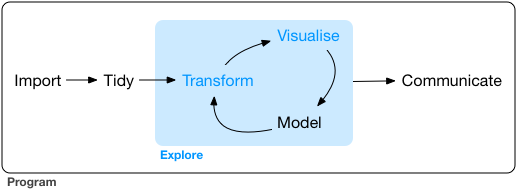

### 3.1 Theming

**Set some global style options for ggplot**

In [188]:
options(repr.plot.width  = 12,
        repr.plot.height = 5, 
        repr.plot.res    = 300)

### 3.2a Visualization, all data
* First lets look at all of the data

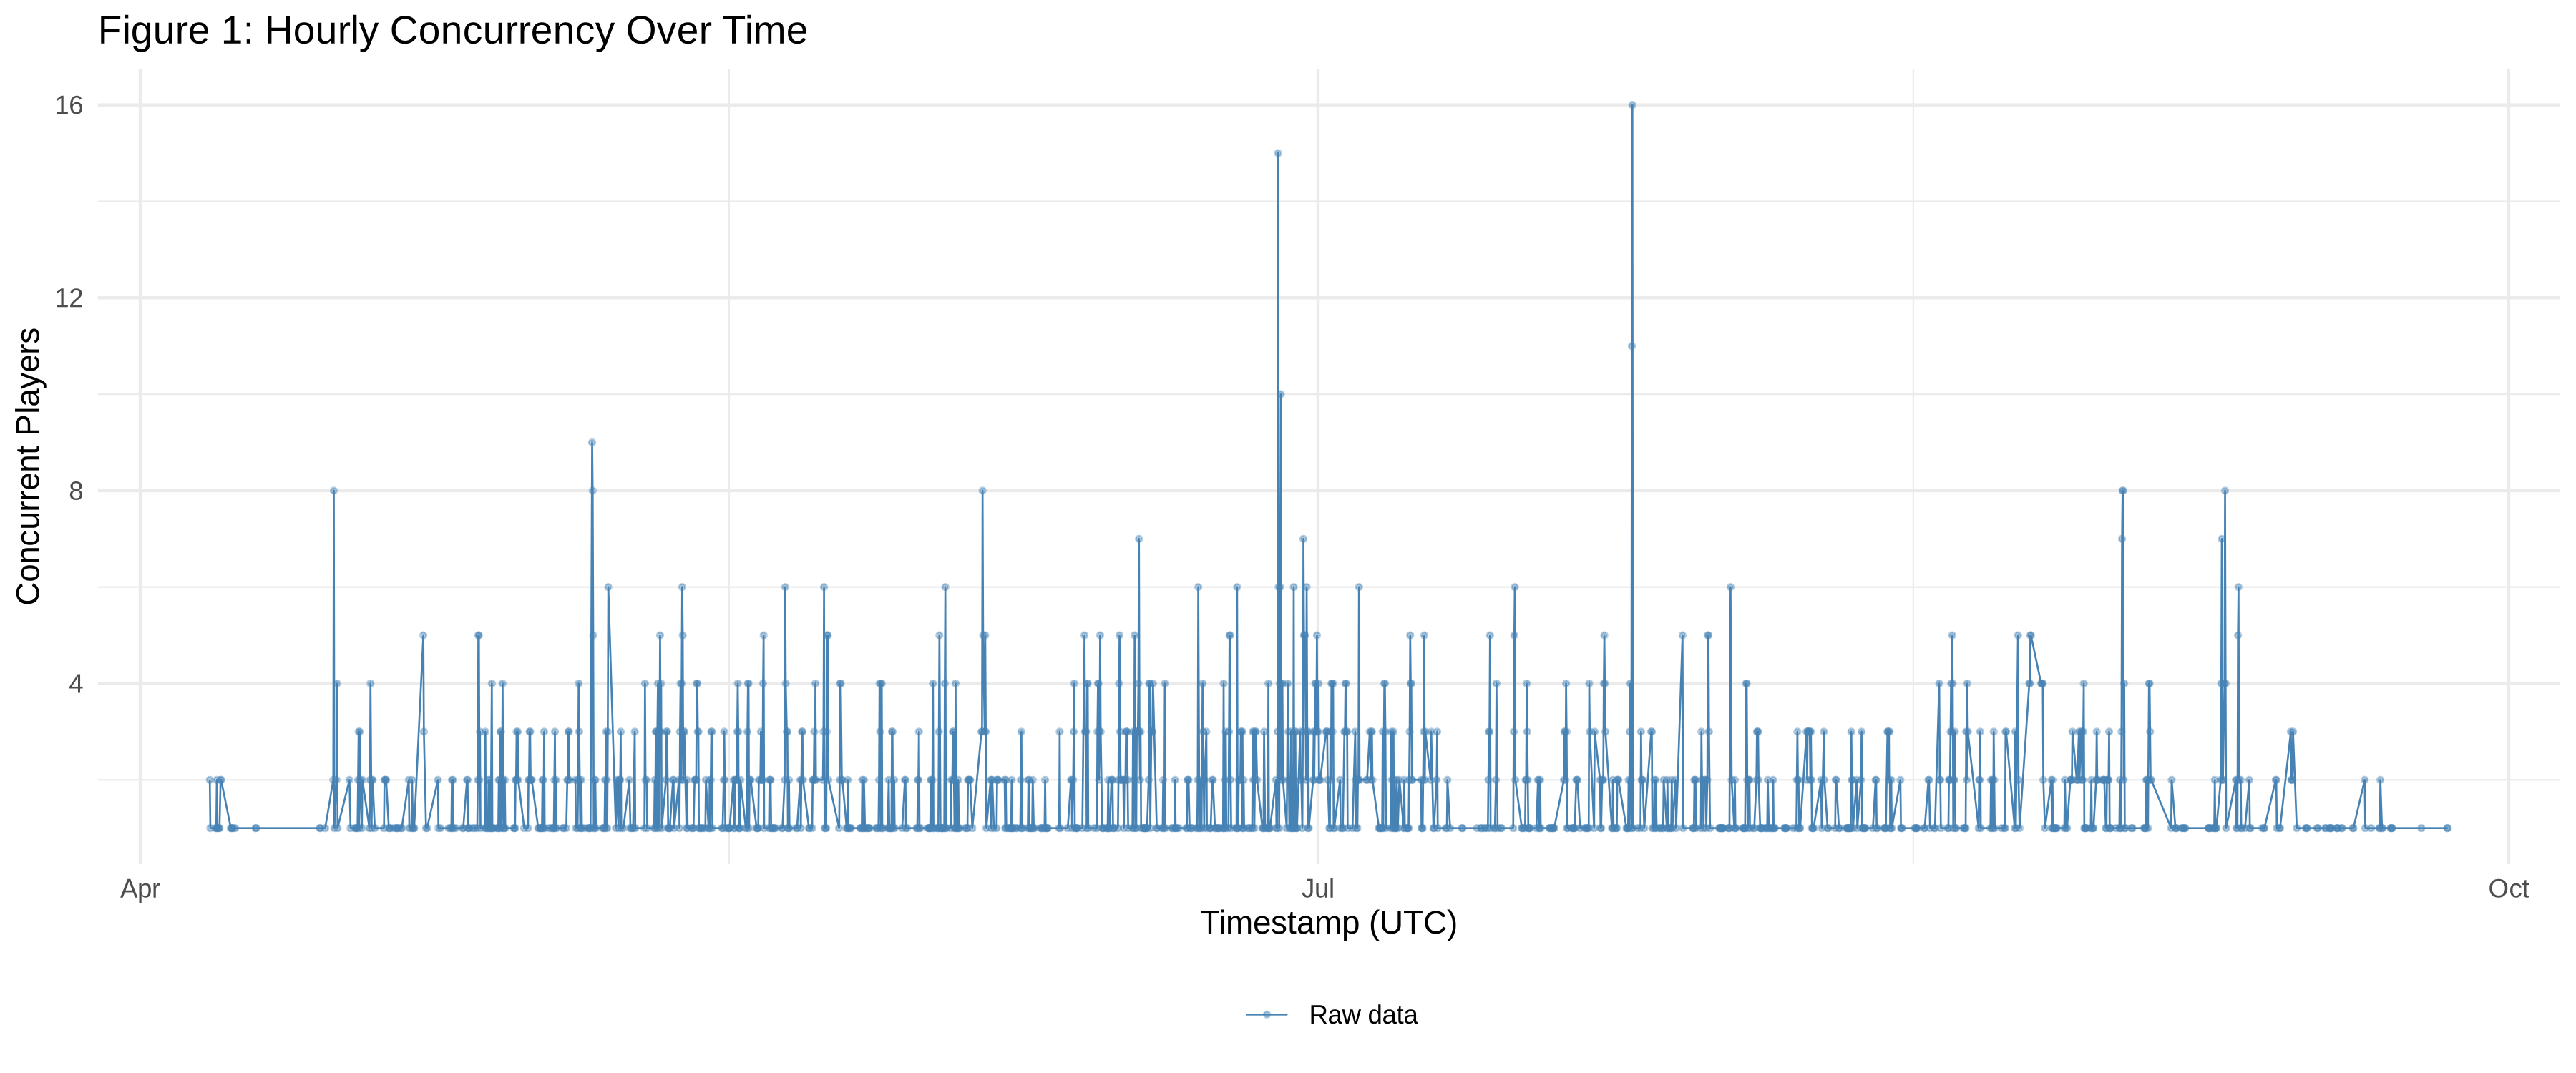

In [219]:
# Step 1: Add a series label to the data
hourly_labeled <- hourly |>
  mutate(series = "Raw data")

# Step 2: Plot with legend mapped to series
ggplot(hourly_labeled, aes(x = hour_seq, y = concurrent_players, colour = series)) +
  geom_line(linewidth = 0.3) +
  geom_point(alpha = 0.4, size = 0.6) +
  scale_colour_manual(values = c("Raw data" = "steelblue")) +
  labs(
    title  = "Figure 1: Hourly Concurrency Over Time",
    x      = "Timestamp (UTC)",
    y      = "Concurrent Players",
    colour = NULL  # removes "series" as legend title
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

### 3.2b Visualization, all data with a rolling average
* Applying a rolly averges shows that there are some trends that we can look into over shorter periods of time

Warning message:
“Removed 23 rows containing missing values or values outside the scale range
(`geom_line()`).”


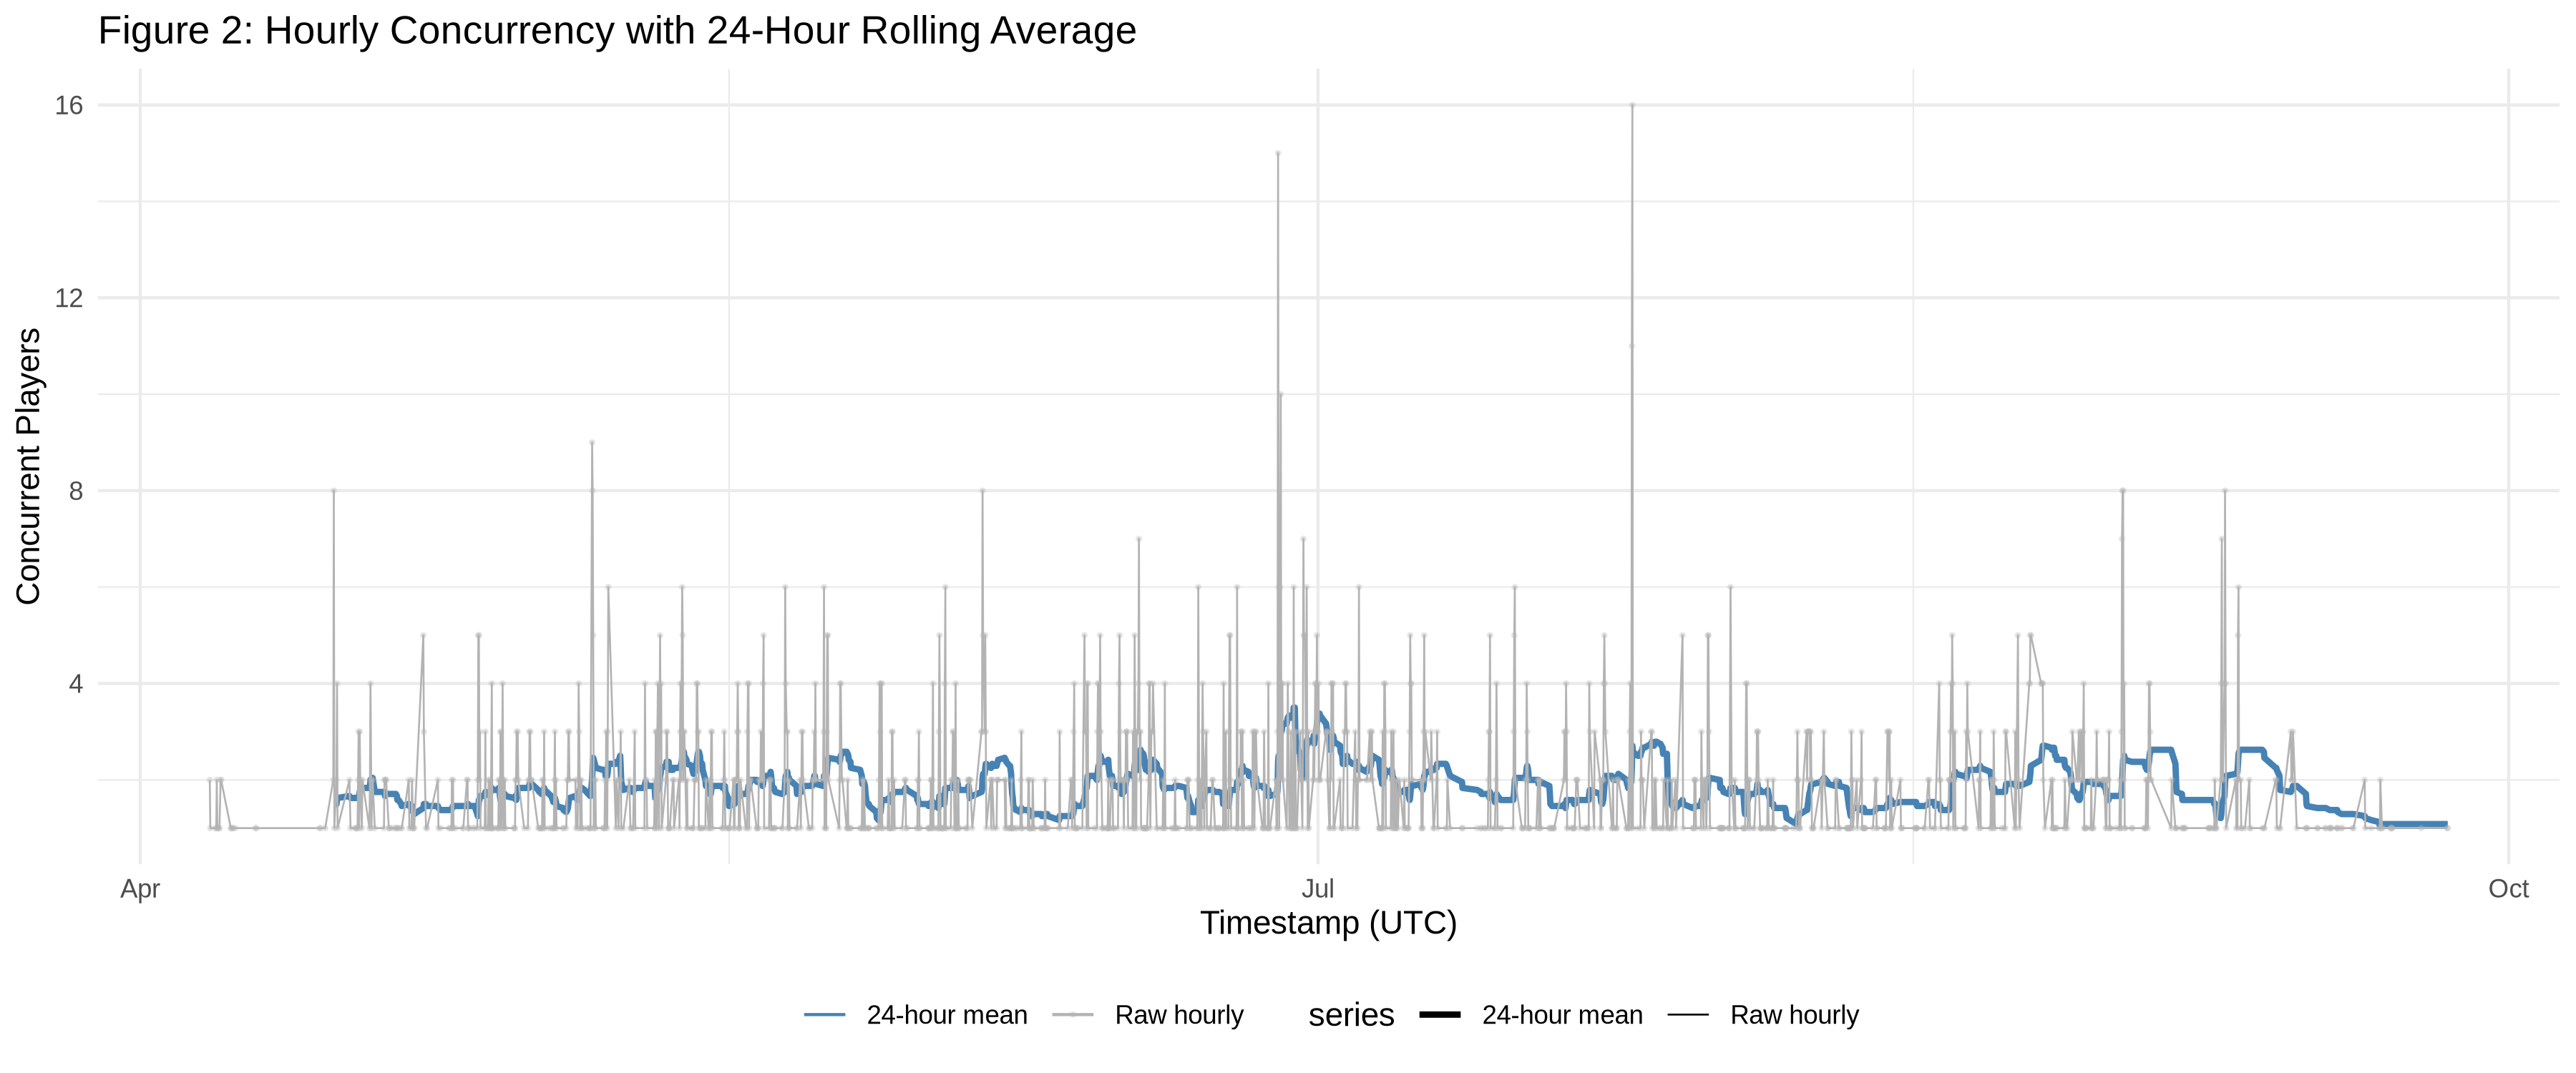

In [218]:
plot_df <- hourly |>
  arrange(hour_seq) |>
  mutate(roll24 = slide_dbl(concurrent_players, mean, .before = 23, .complete = TRUE)) |>
  select(hour_seq,
         `Raw hourly` = concurrent_players,
         `24-hour mean` = roll24) |>
  pivot_longer(-hour_seq, names_to = "series", values_to = "players")

ggplot(plot_df, aes(x = hour_seq, y = players, colour = series)) +
  geom_line(aes(linewidth = series)) +
  geom_point(
    data = subset(plot_df, series == "Raw hourly"),
    alpha = 0.25, size = 0.4
  ) +
  scale_colour_manual(
    values = c("Raw hourly" = "grey70", "24-hour mean" = "steelblue")
  ) +
  scale_linewidth_manual(
    values = c("Raw hourly" = 0.3, "24-hour mean" = 1)
  ) +
  labs(
    title   = "Figure 2: Hourly Concurrency with 24-Hour Rolling Average",
    x       = "Timestamp (UTC)",
    y       = "Concurrent Players",
    colour  = NULL
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

### 3.2c Visualization, accross diffrent time frames
* By looking at data over different time frames we are able to get a better understanding of trends and patterns
* We initially see that all of the timeframes have a pattern, however this only only due to the automatic scalling
* Looking purely based on the shape, day of the month and hour of the day have the clearest patterns

**Note we dont have didn't have a good way to facet all of the graphs together, so we had to use the gridwork library**

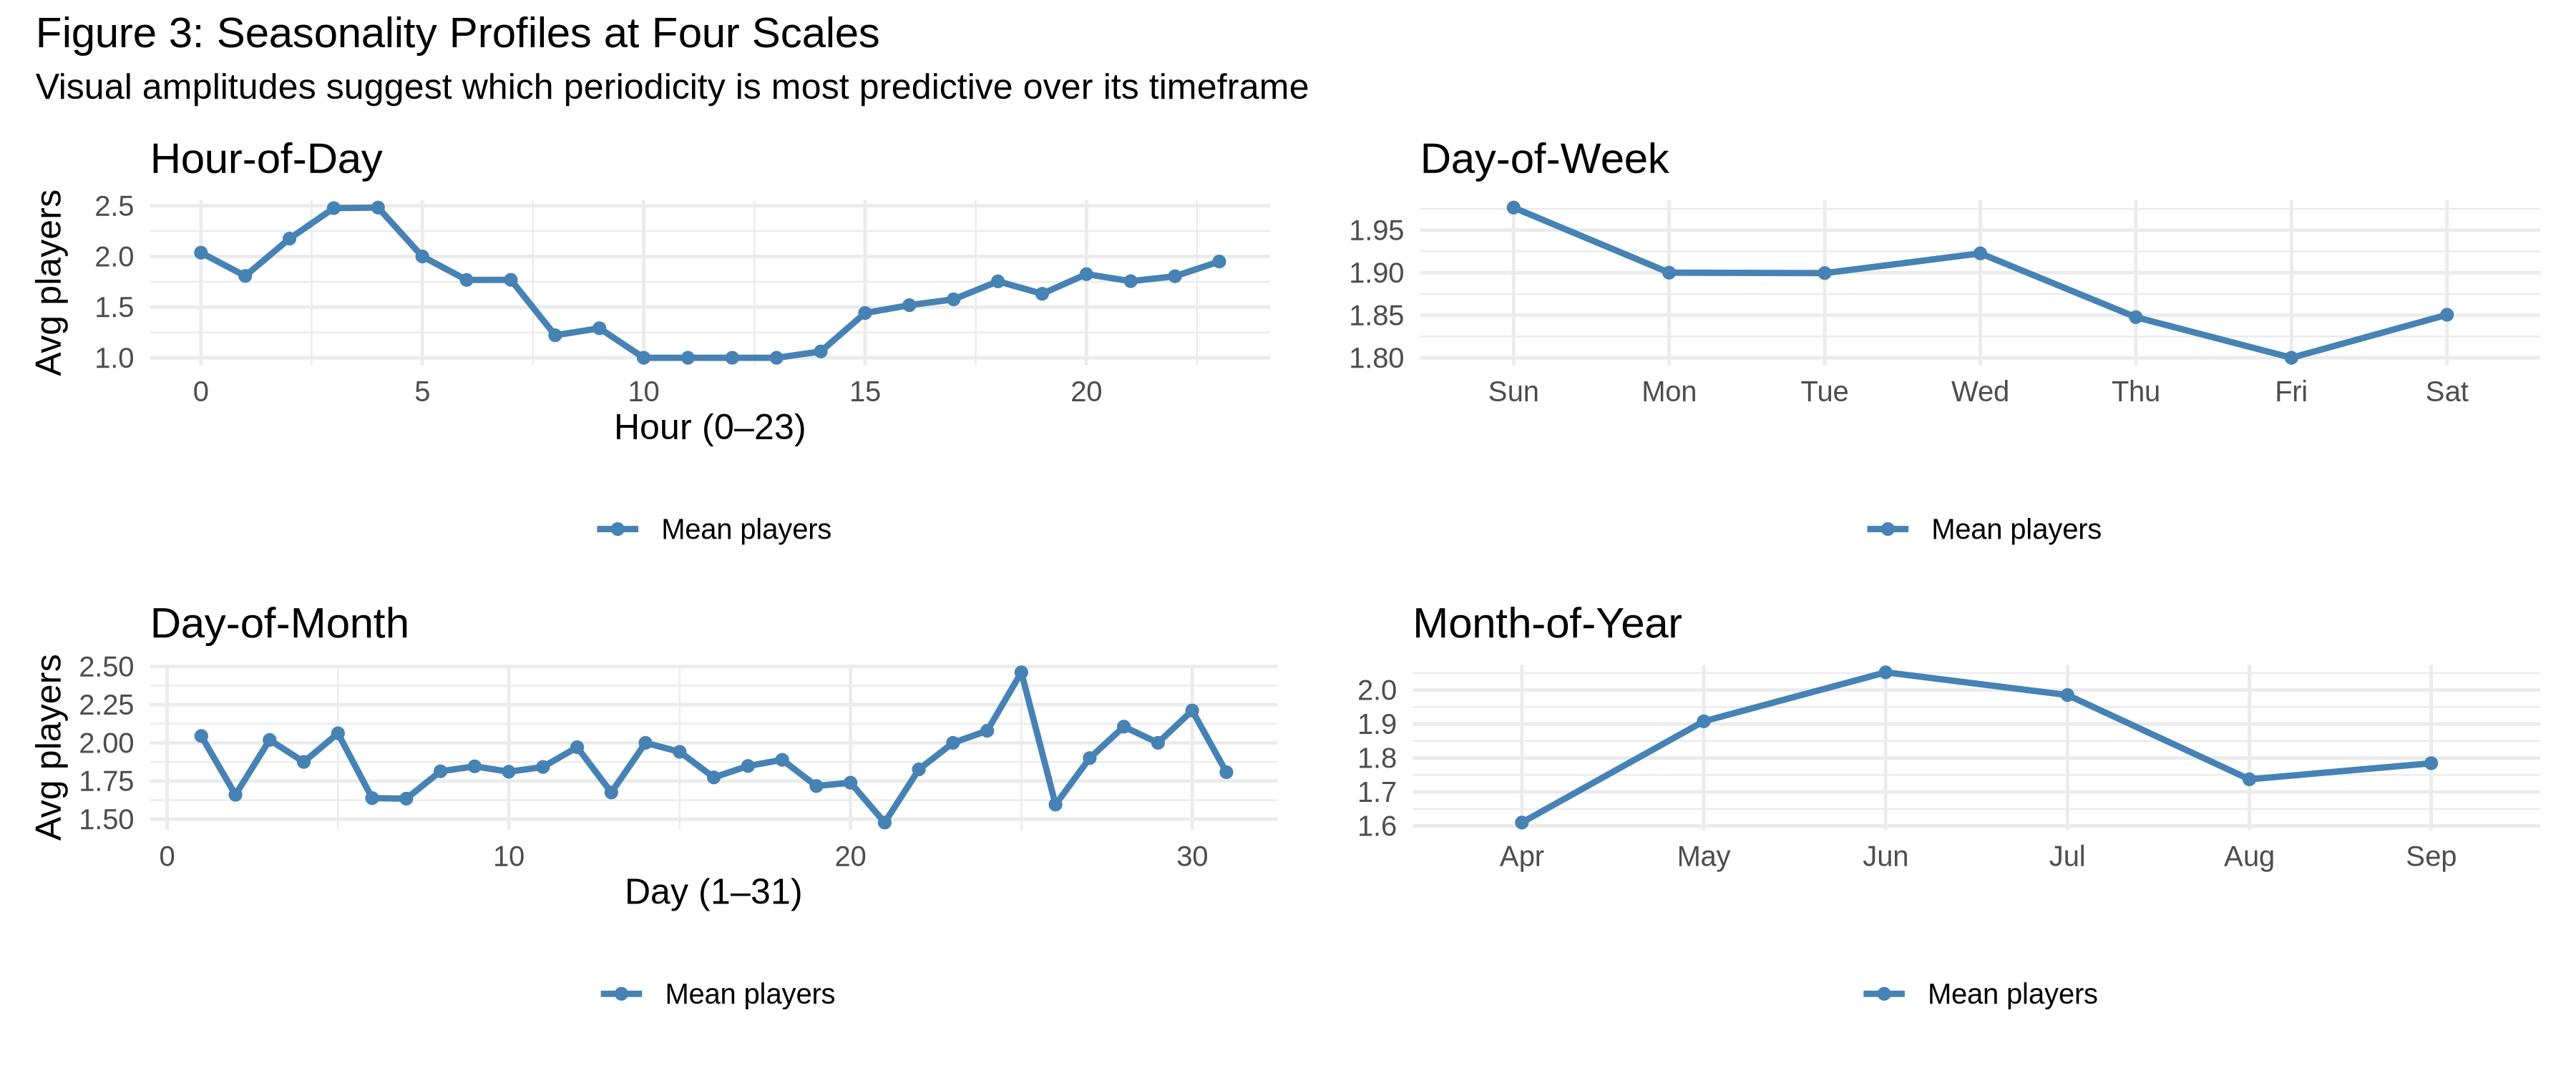

In [221]:
# 1 Hour-of-day profile
p_day <- hourly |>
  mutate(hour = hour(hour_seq), series = "Mean players") |>
  group_by(hour, series) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(hour, mean_players, colour = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Mean players" = "steelblue")) +
  labs(title = "Hour-of-Day", x = "Hour (0–23)", y = "Avg players", colour = NULL)

# 2 Day-of-week profile
p_week <- hourly |>
  mutate(wday = wday(hour_seq, label = TRUE, abbr = TRUE), series = "Mean players") |>
  group_by(wday, series) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(wday, mean_players, colour = series, group = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Mean players" = "steelblue")) +
  labs(title = "Day-of-Week", x = "", y = "", colour = NULL)

# 3 Day-of-month profile
p_month <- hourly |>
  mutate(dom = day(hour_seq), series = "Mean players") |>
  group_by(dom, series) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(dom, mean_players, colour = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Mean players" = "steelblue")) +
  labs(title = "Day-of-Month", x = "Day (1–31)", y = "Avg players", colour = NULL)

# 4 Month-of-year profile
p_year <- hourly |>
  mutate(mon = month(hour_seq, label = TRUE, abbr = TRUE), series = "Mean players") |>
  group_by(mon, series) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(mon, mean_players, colour = series, group = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Mean players" = "steelblue")) +
  labs(title = "Month-of-Year", x = "", y = "", colour = NULL)

# Combine into a 2 × 2 grid with a shared legend and title
(p_day | p_week) /
(p_month | p_year) +
  plot_annotation(
    title = "Figure 3: Seasonality Profiles at Four Scales",
    subtitle = "Visual amplitudes suggest which periodicity is most predictive over its timeframe"
  ) &
  theme(legend.position = "bottom")

### 3.3a Transformation, volatility
**Calculating the numeric amplitude (max − min) after visually comparing the facets gives an objective, scale-independent measure of each cycle’s volatility, confirming which seasonal pattern is truly strongest.**

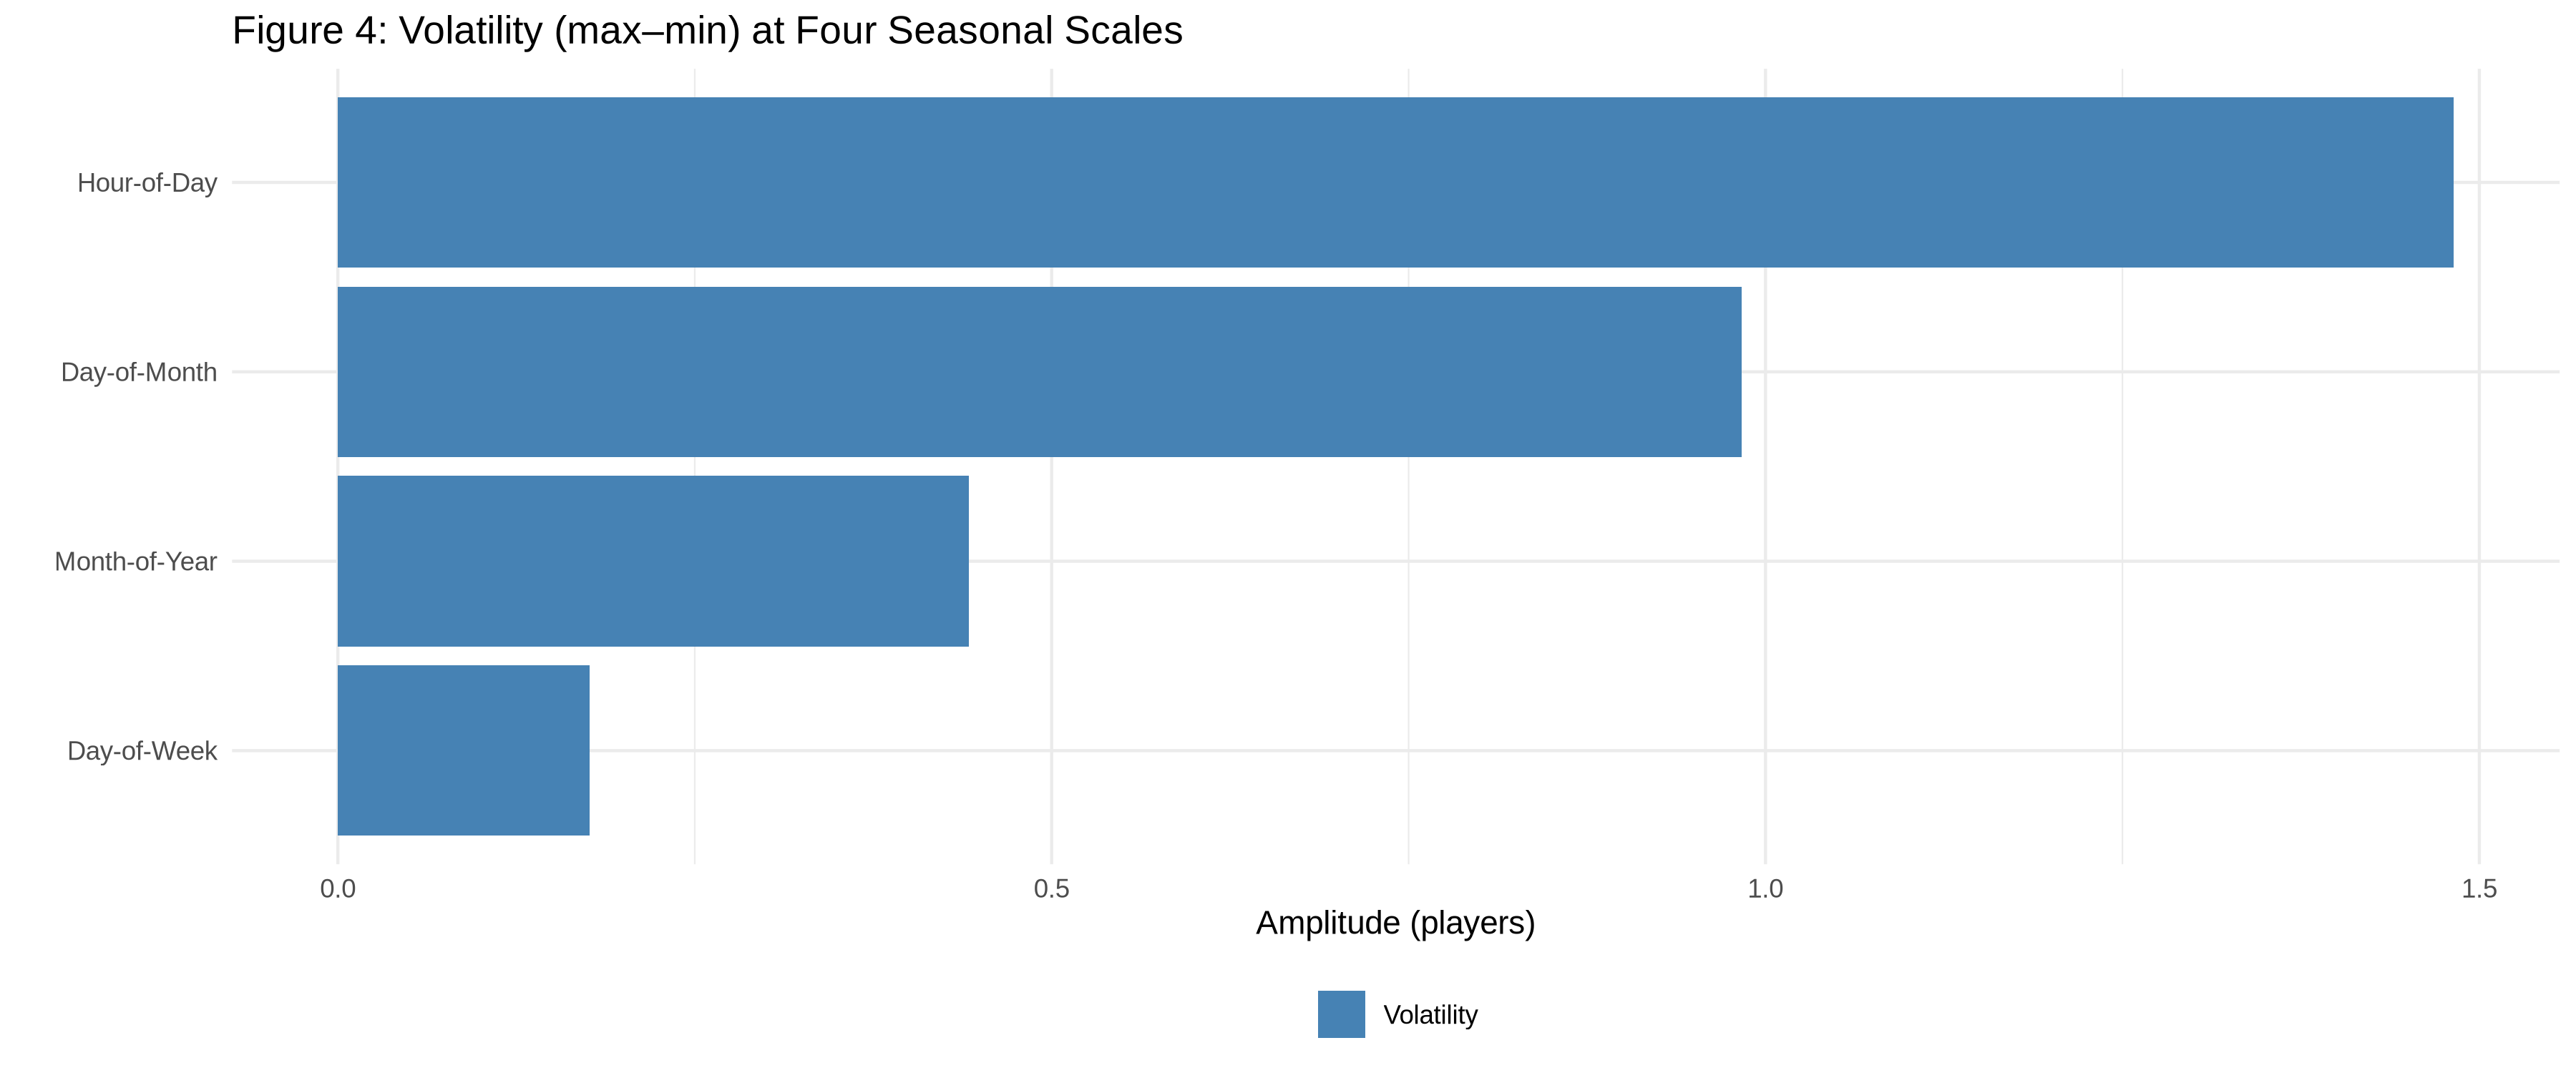

In [222]:
vol_df <- seasons |>
  mutate(amp = map_dbl(fn, \(f)
    hourly |>
      mutate(key = f(hour_seq)) |>
      group_by(key) |>
      summarise(avg = mean(concurrent_players), .groups = "drop") |>
      summarise(max(avg) - min(avg)) |>
      pull()
  )) |>
  mutate(series = "Volatility")

ggplot(vol_df, aes(x = reorder(scale, amp), y = amp, fill = series)) +
  geom_col() +
  coord_flip() +
  scale_fill_manual(values = c("Volatility" = "steelblue")) +
  labs(
    title  = "Figure 4: Volatility (max–min) at Four Seasonal Scales",
    x      = "",
    y      = "Amplitude (players)",
    fill   = NULL  
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

### 3.3a Transformation, Sample coverage
Our volatility is only good if we have enough data points to fit it on

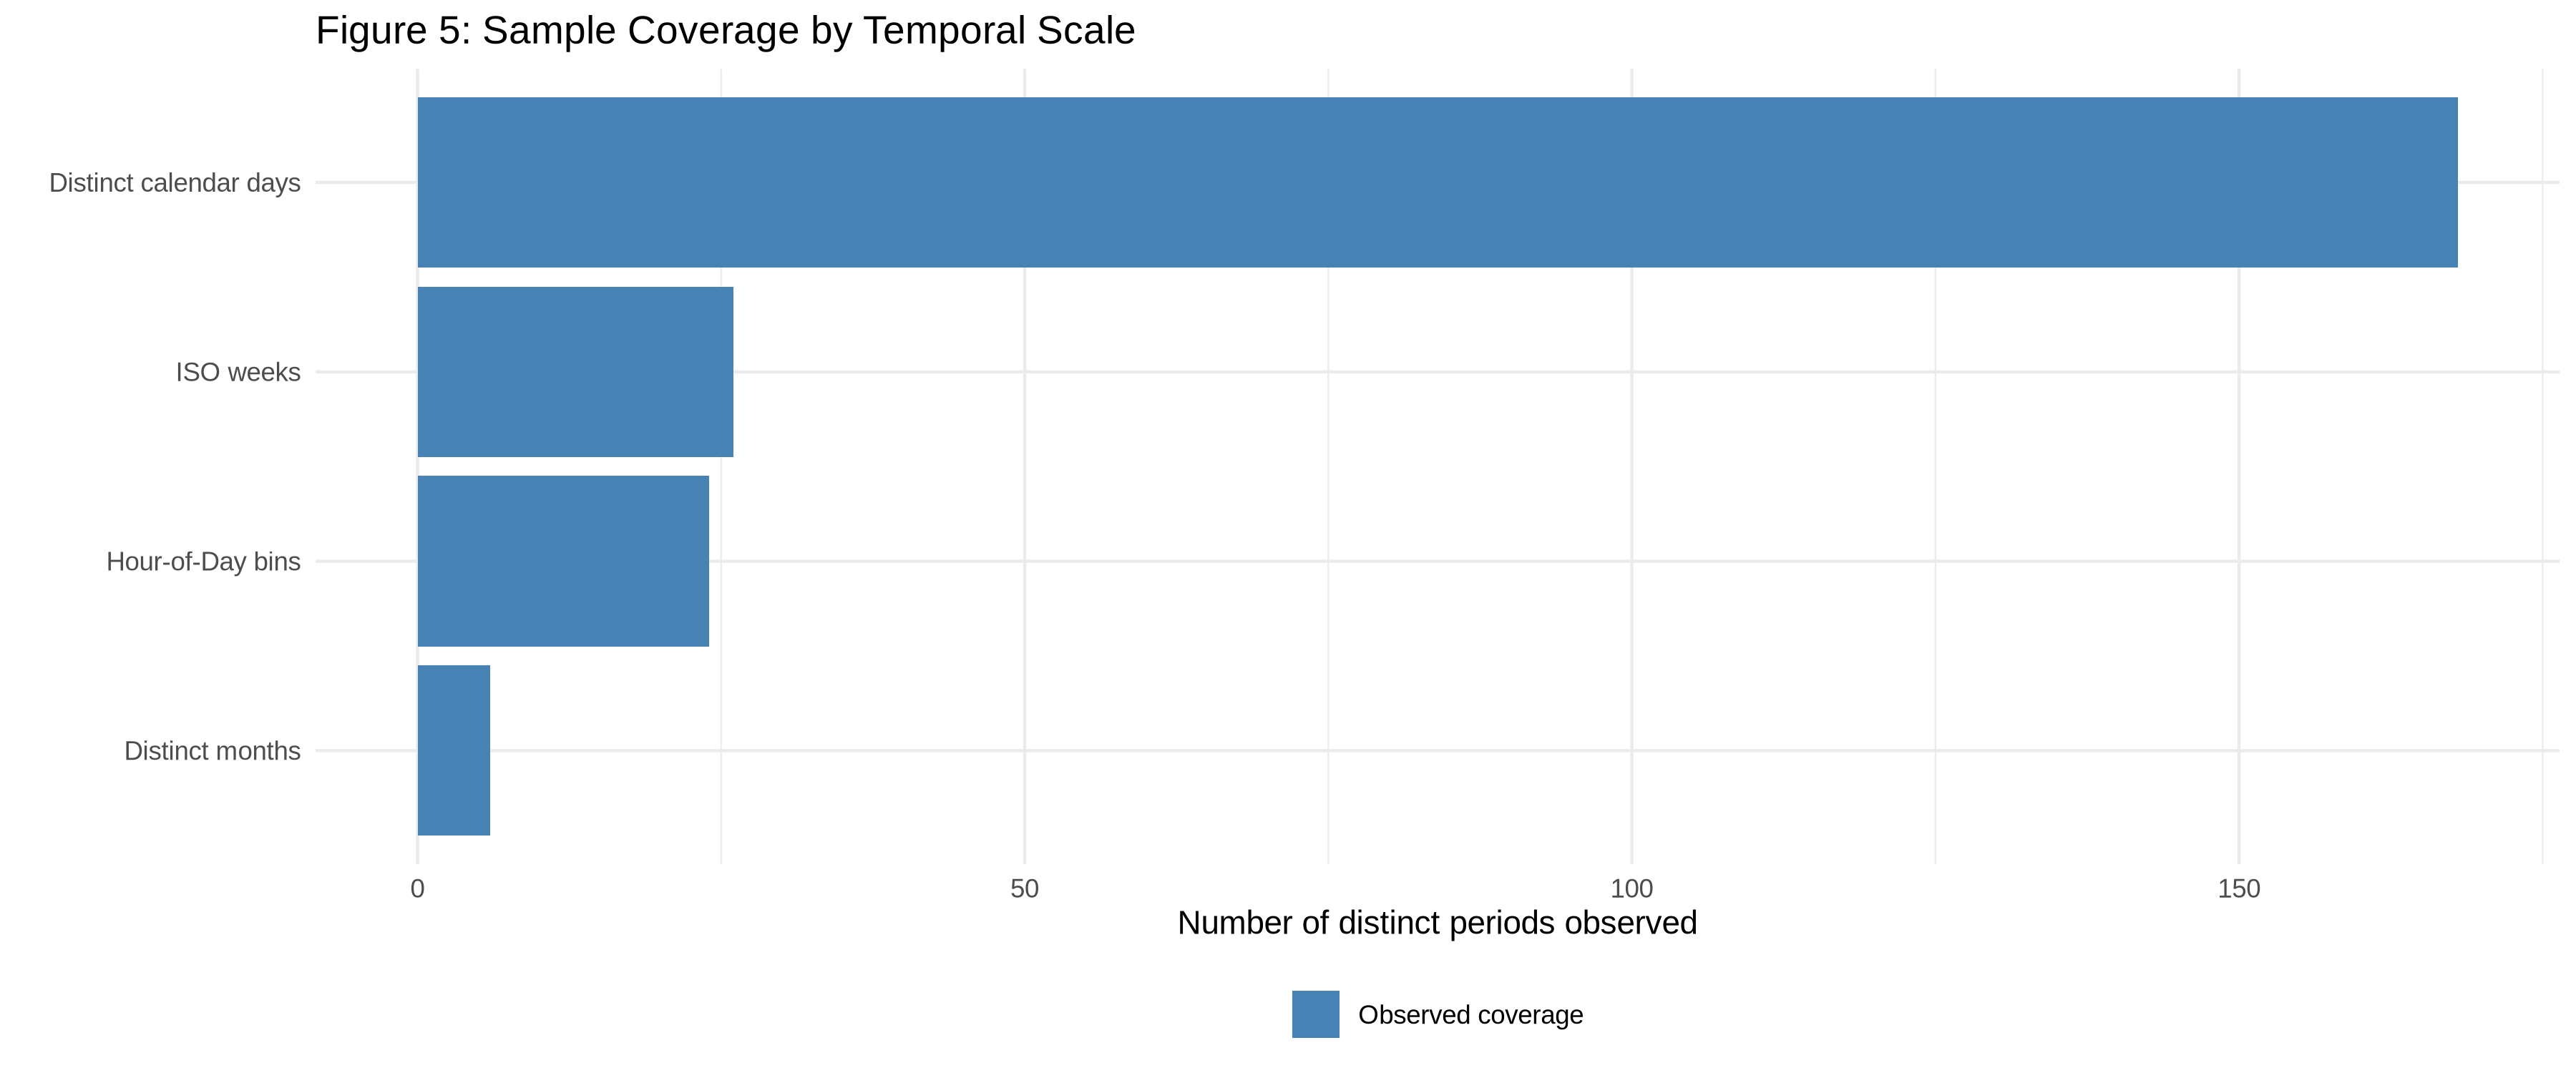

In [223]:
# Create keys and count distinct time periods
coverage_df <- hourly |>
  transmute(
    hour_key  = hour(hour_seq),                       # 0–23  (24 possible)
    day_key   = as_date(hour_seq),                    # calendar date
    week_key  = paste0(year(hour_seq), "-W", isoweek(hour_seq)),
    month_key = floor_date(hour_seq, unit = "month")
  ) |>
  summarise(
    hours  = n_distinct(hour_key),
    days   = n_distinct(day_key),
    weeks  = n_distinct(week_key),
    months = n_distinct(month_key)
  ) |>
  pivot_longer(everything(),
               names_to  = "scale",
               values_to = "n_periods") |>
  mutate(
    scale = recode(scale,
                   hours  = "Hour-of-Day bins",
                   days   = "Distinct calendar days",
                   weeks  = "ISO weeks",
                   months = "Distinct months"),
    series = "Observed coverage"
  )

# Plot with mapped fill
ggplot(coverage_df, aes(x = reorder(scale, n_periods), y = n_periods, fill = series)) +
  geom_col() +
  coord_flip() +
  scale_fill_manual(values = c("Observed coverage" = "steelblue")) +
  labs(
    title = "Figure 5: Sample Coverage by Temporal Scale",
    x = "", y = "Number of distinct periods observed",
    fill = NULL  # removes "series" label in the legend
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

## 4 Model
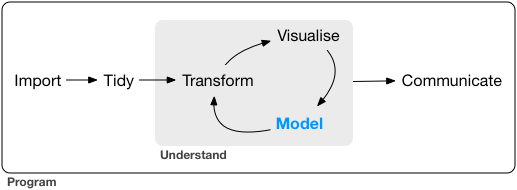

**Now we can proceed with creating a model that can answer our predictive question**

### 4.1 Feature Engineering

To make accurate predictions, we engineered two key lag features: `lag1` (player count one hour earlier) and `lag24` (same hour the previous day). These were chosen to reflect both short-term momentum and daily cycle effects.

Our approach was informed by external resources, including [**Forecasting: Principles and Practice** (3rd ed.)](https://otexts.com/fpp3/) and Section 2.7 on Lag Plots from *Forecasting* (n.d.). These helped us understand how recent values can carry signal for near-future behavior, especially in time series with seasonal patterns.

In addition to lagged features, we also added time-based indicators such as hour-of-day, day-of-week, and month to help the model account for regular seasonal variation in player behavior.

In [194]:
lagged_cat <- hourly |>
  arrange(hour_seq) |> # arrgenges for the split
  mutate(
    lag1  = lag(concurrent_players,  1),
    lag24 = lag(concurrent_players, 24),
    hour  = factor(hour(hour_seq), levels = 0:23),   # 24-level factor(hours)
    dom   = factor(day(hour_seq))                    # up to 31 levels(days)
  ) |>
  drop_na()                                          # remove first 24 rows

### 4.2 Chronological split (reuse 80/20)

In [195]:
split_cat <- initial_time_split(lagged_cat, prop = 0.80)
train_cat <- training(split_cat)
test_cat  <- testing(split_cat)

### 4.3 Recipe: one-hot encode hour & dom, standardise numeric lags

In [196]:
rec_cat <- recipe(concurrent_players ~ lag1 + lag24 + hour + dom,
                  data = train_cat) |>
  step_center(all_numeric_predictors()) |>
  step_scale(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors())

### 4.4 Model spec & workflow

In [197]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

wf_cat <- workflow() |>
  add_recipe(rec_cat) |>
  add_model(lm_spec)

### 4.5  5-fold CV on training set

In [207]:
folds_cat <- vfold_cv(train_cat, v = 5)

cv_cat <- fit_resamples(
  wf_cat,
  resamples = folds_cat,
  metrics   = metric_set(rmse, mae)
)

### 4.6  Final fit and hold-out(testing set) evaluation 

In [199]:
fit_cat <- fit(wf_cat, data = train_cat)

pred_cat <- predict(fit_cat, new_data = test_cat) |>
  bind_cols(test_cat)

## 5 Visualizing the Results

After training the model, we used it to generate predicted player counts (`.pred`) for every hour in the dataset. We then visualized how these predictions varied across different time scales—such as hour of day and day of month—to better understand the model’s behavior.

The plots show that the model captures key seasonal trends, including higher activity during certain hours and predictable drops during off-peak times. In addition, we compared the predicted values against actual player counts from a hold-out test set to evaluate accuracy. The close alignment between predicted and observed patterns in these visualizations supports the model’s usefulness for short-term load forecasting.

### 5.1 Model predions graphically

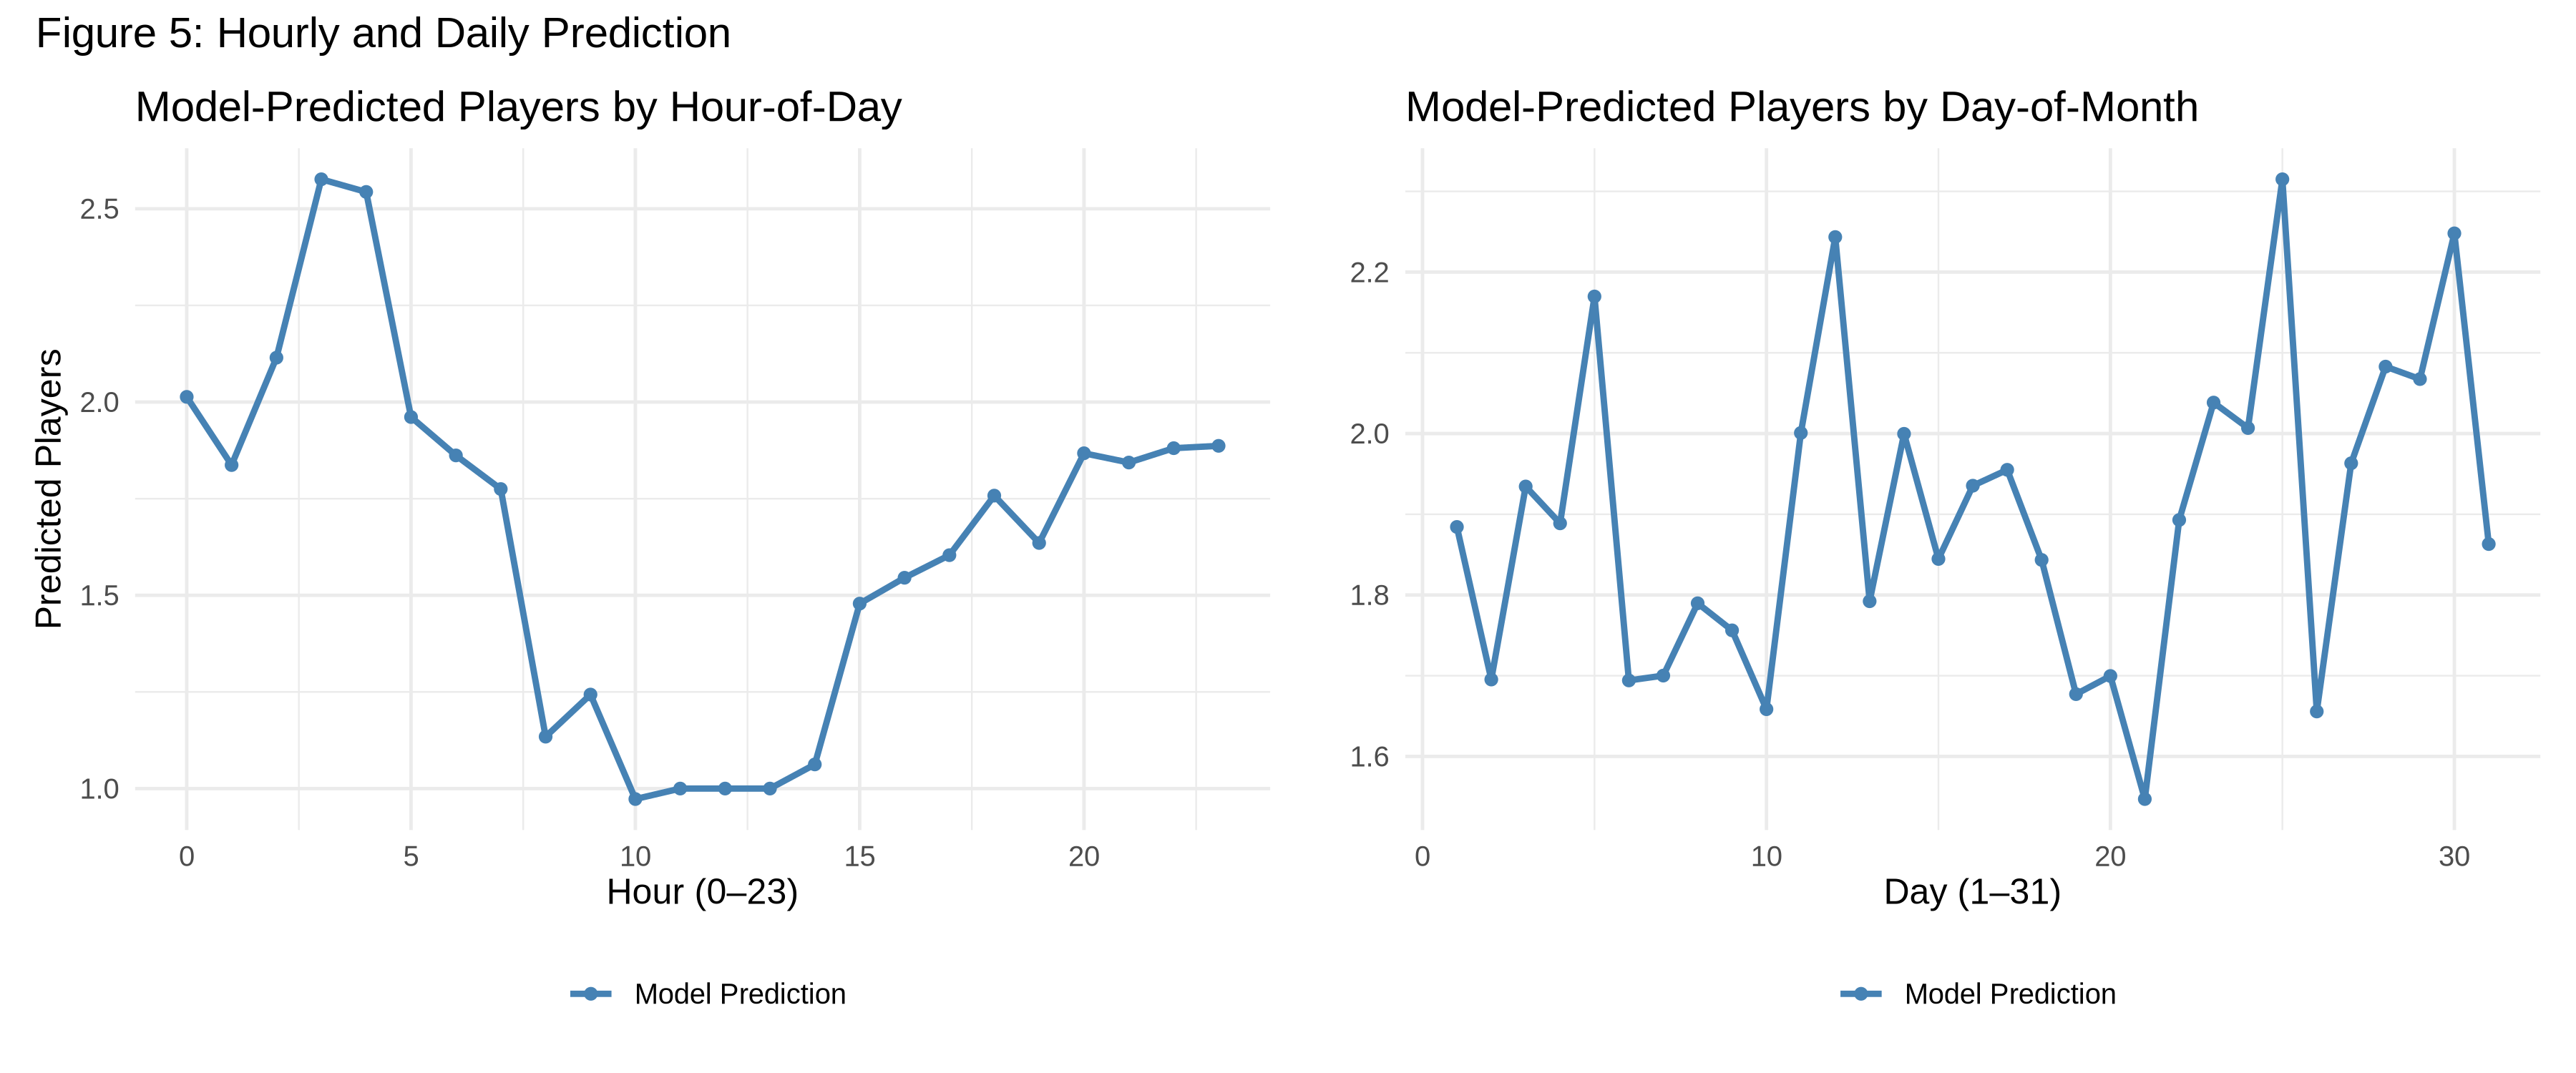

In [225]:
# Add model predictions
pred_df <- predict(fit_cat, new_data = lagged_cat) |>
  bind_cols(lagged_cat) |> 
  mutate(series = "Model Prediction")  # For legend mapping

# Hour-of-day effect
p_hour <- pred_df |>
  group_by(hour, series) |>
  summarise(pred_mean = mean(.pred), .groups = "drop") |>
  ggplot(aes(as.integer(as.character(hour)), pred_mean, colour = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Model Prediction" = "steelblue")) +
  labs(
    title = "Model-Predicted Players by Hour-of-Day",
    x     = "Hour (0–23)",
    y     = "Predicted Players",
    colour = NULL
  )

# Day-of-month effect
p_dom <- pred_df |>
  group_by(dom, series) |>
  summarise(pred_mean = mean(.pred), .groups = "drop") |>
  ggplot(aes(as.integer(as.character(dom)), pred_mean, colour = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c("Model Prediction" = "steelblue")) +
  labs(
    title = "Model-Predicted Players by Day-of-Month",
    x     = "Day (1–31)",
    y     = "",
    colour = NULL
  )

# Combine with shared legend
(p_hour | p_dom) +
  plot_annotation(
    title = "Figure 5: Hourly and Daily Prediction"
  ) &
  theme(legend.position = "bottom")

### 5.2 Model predions compared to testing data

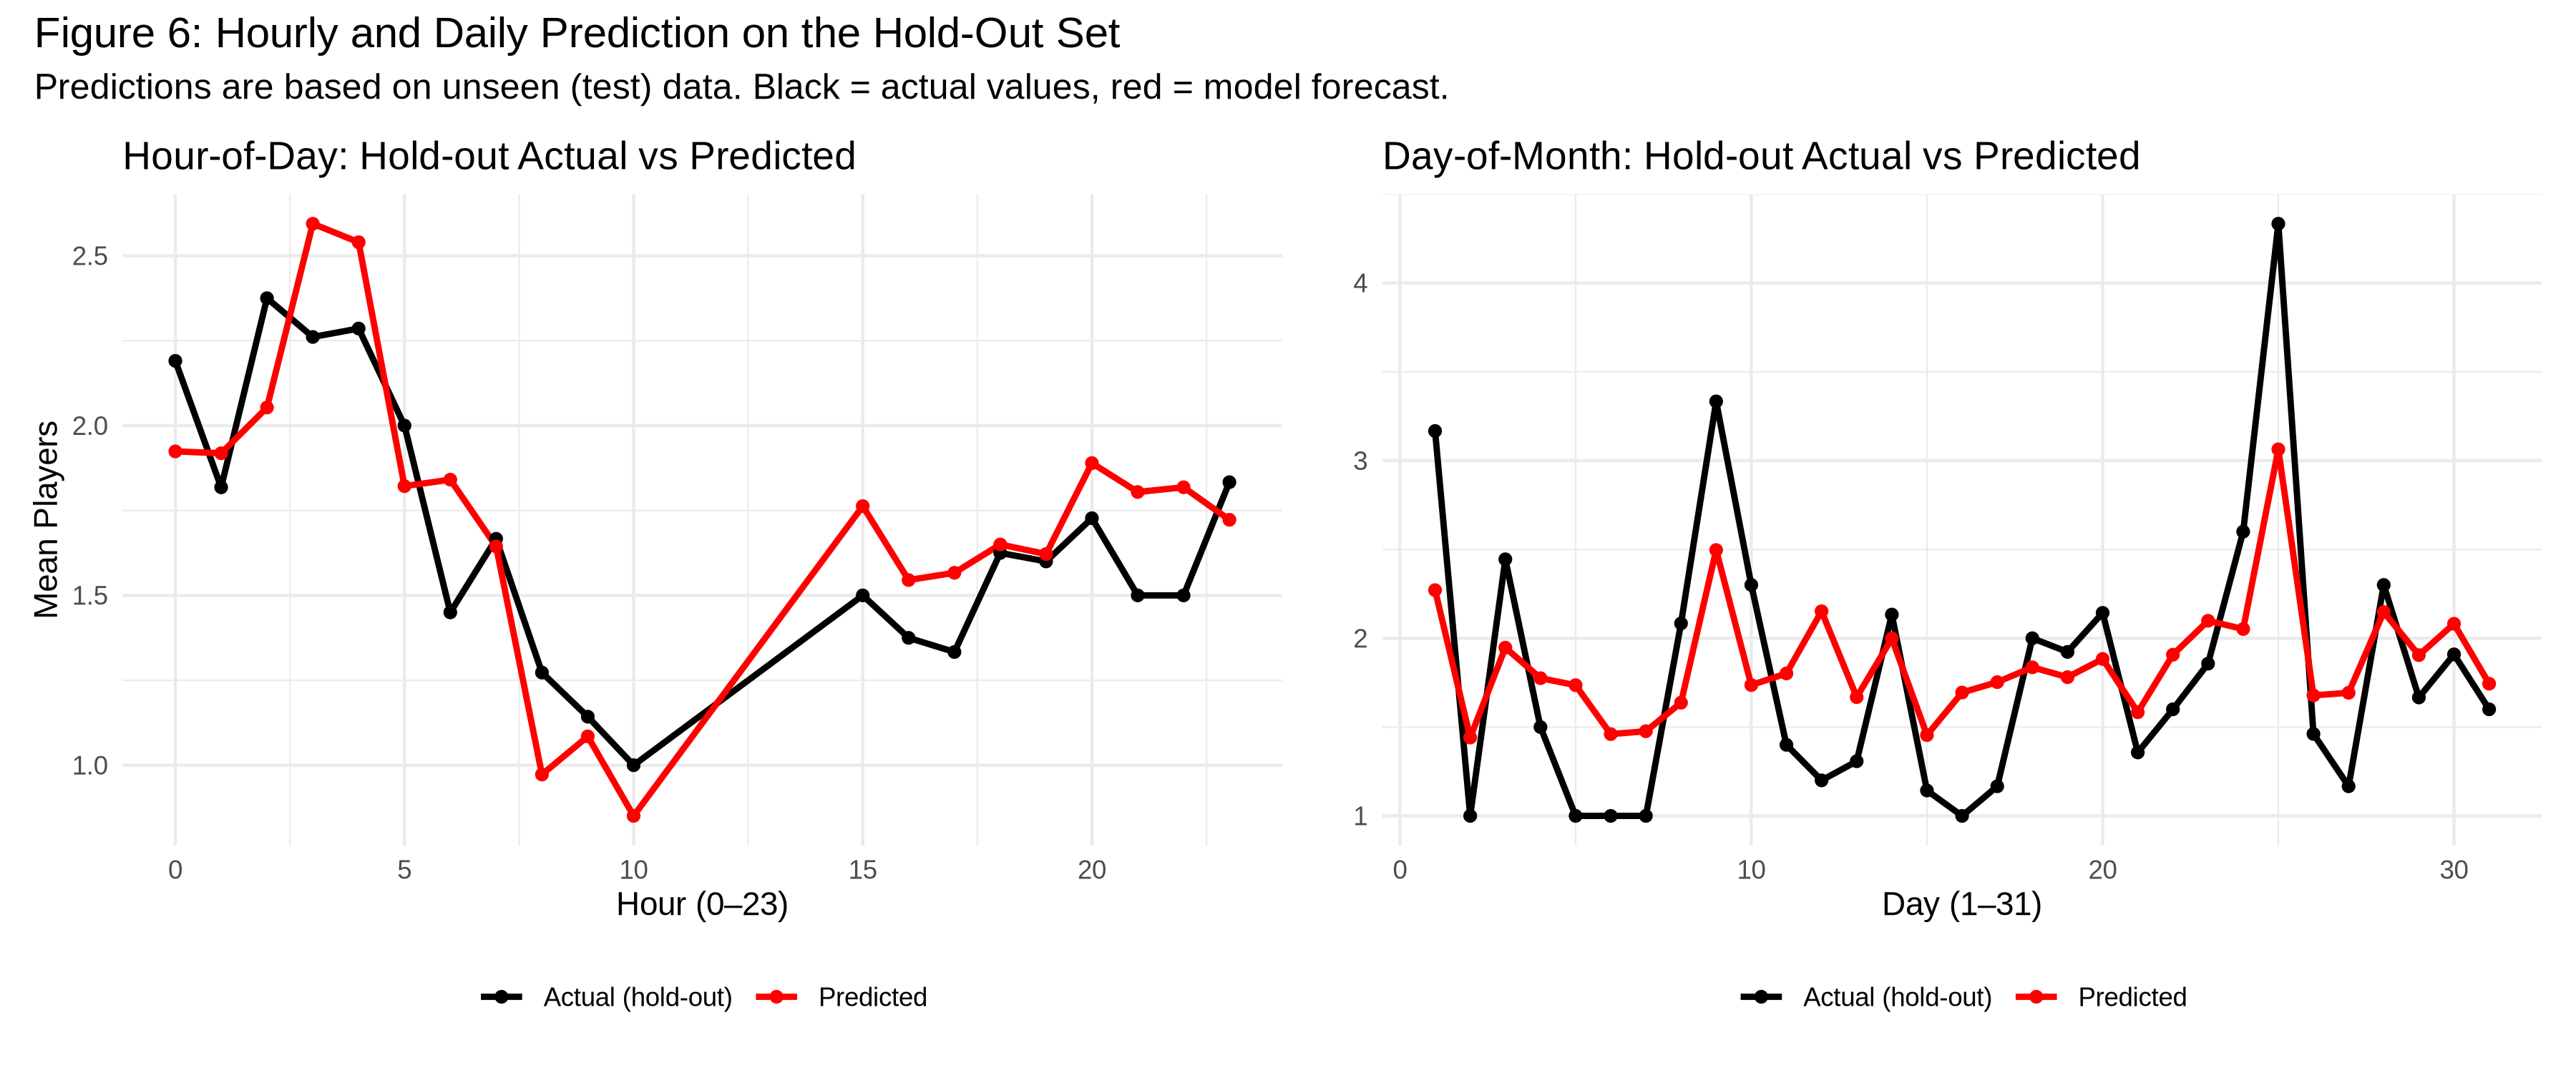

In [227]:
# Get predictions for the hold-out set
test_pred <- predict(fit_cat, new_data = test_cat) |> 
  bind_cols(test_cat)

# Hour-of-day comparison
hour_hold <- test_pred |>
  group_by(hour) |>
  summarise(
    actual    = mean(concurrent_players),
    predicted = mean(.pred),
    .groups   = "drop"
  ) |>
  pivot_longer(
    c(actual, predicted),
    names_to  = "series",
    values_to = "mean_players"
  ) |>
  mutate(series = factor(series, levels = c("actual", "predicted")))

p_hour <- ggplot(hour_hold,
                 aes(x = as.integer(as.character(hour)),
                     y = mean_players,
                     colour = series,
                     group = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(
    values = c("actual" = "black", "predicted" = "red"),
    labels = c("Actual (hold-out)", "Predicted")
  ) +
  labs(
    title = "Hour-of-Day: Hold-out Actual vs Predicted",
    x     = "Hour (0–23)",
    y     = "Mean Players",
    colour = NULL
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

# Day-of-month comparison
dom_hold <- test_pred |>
  group_by(dom) |>
  summarise(
    actual    = mean(concurrent_players),
    predicted = mean(.pred),
    .groups   = "drop"
  ) |>
  pivot_longer(
    c(actual, predicted),
    names_to  = "series",
    values_to = "mean_players"
  ) |>
  mutate(series = factor(series, levels = c("actual", "predicted")))

p_dom <- ggplot(dom_hold,
                aes(x = as.integer(as.character(dom)),
                    y = mean_players,
                    colour = series,
                    group = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(
    values = c("actual" = "black", "predicted" = "red"),
    labels = c("Actual (hold-out)", "Predicted")
  ) +
  labs(
    title = "Day-of-Month: Hold-out Actual vs Predicted",
    x     = "Day (1–31)",
    y     = "",
    colour = NULL
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

# Combine both with shared annotation
(p_hour | p_dom) +
  plot_annotation(
    title = "Figure 6: Hourly and Daily Prediction on the Hold-Out Set",
    subtitle = "Predictions are based on unseen (test) data. Black = actual values, red = model forecast."
  )

### 5.3 Accuracy metrics

In [238]:
# RMSE
rmse_holdout <- test_pred |>
  summarize(rmse = sqrt(mean((concurrent_players - .pred)^2))) |>
  pull(rmse)

# R-squared
rsq_holdout <- test_pred |>
  summarize(
    rsq = 1 - sum((concurrent_players - .pred)^2) / 
              sum((concurrent_players - mean(concurrent_players))^2)
  ) |>
  pull(rsq)

# Combine into a summary tibble
final_holdout_metrics <- tibble(
  Metric = c("RMSE", "MAE", "R-squared"),
  Value = round(c(rmse_holdout, mae_holdout, rsq_holdout), 2)
)

cat("Table 1: Hold-Out Accuracy Metrics\n\n")

print(final_holdout_metrics)

Table 1: Hold-Out Accuracy Metrics

# A tibble: 3 × 2
  Metric    Value
  <chr>     <dbl>
1 RMSE       1.08
2 MAE        0.78
3 R-squared  0.27


### 5.4 Linear Regresion Preditions

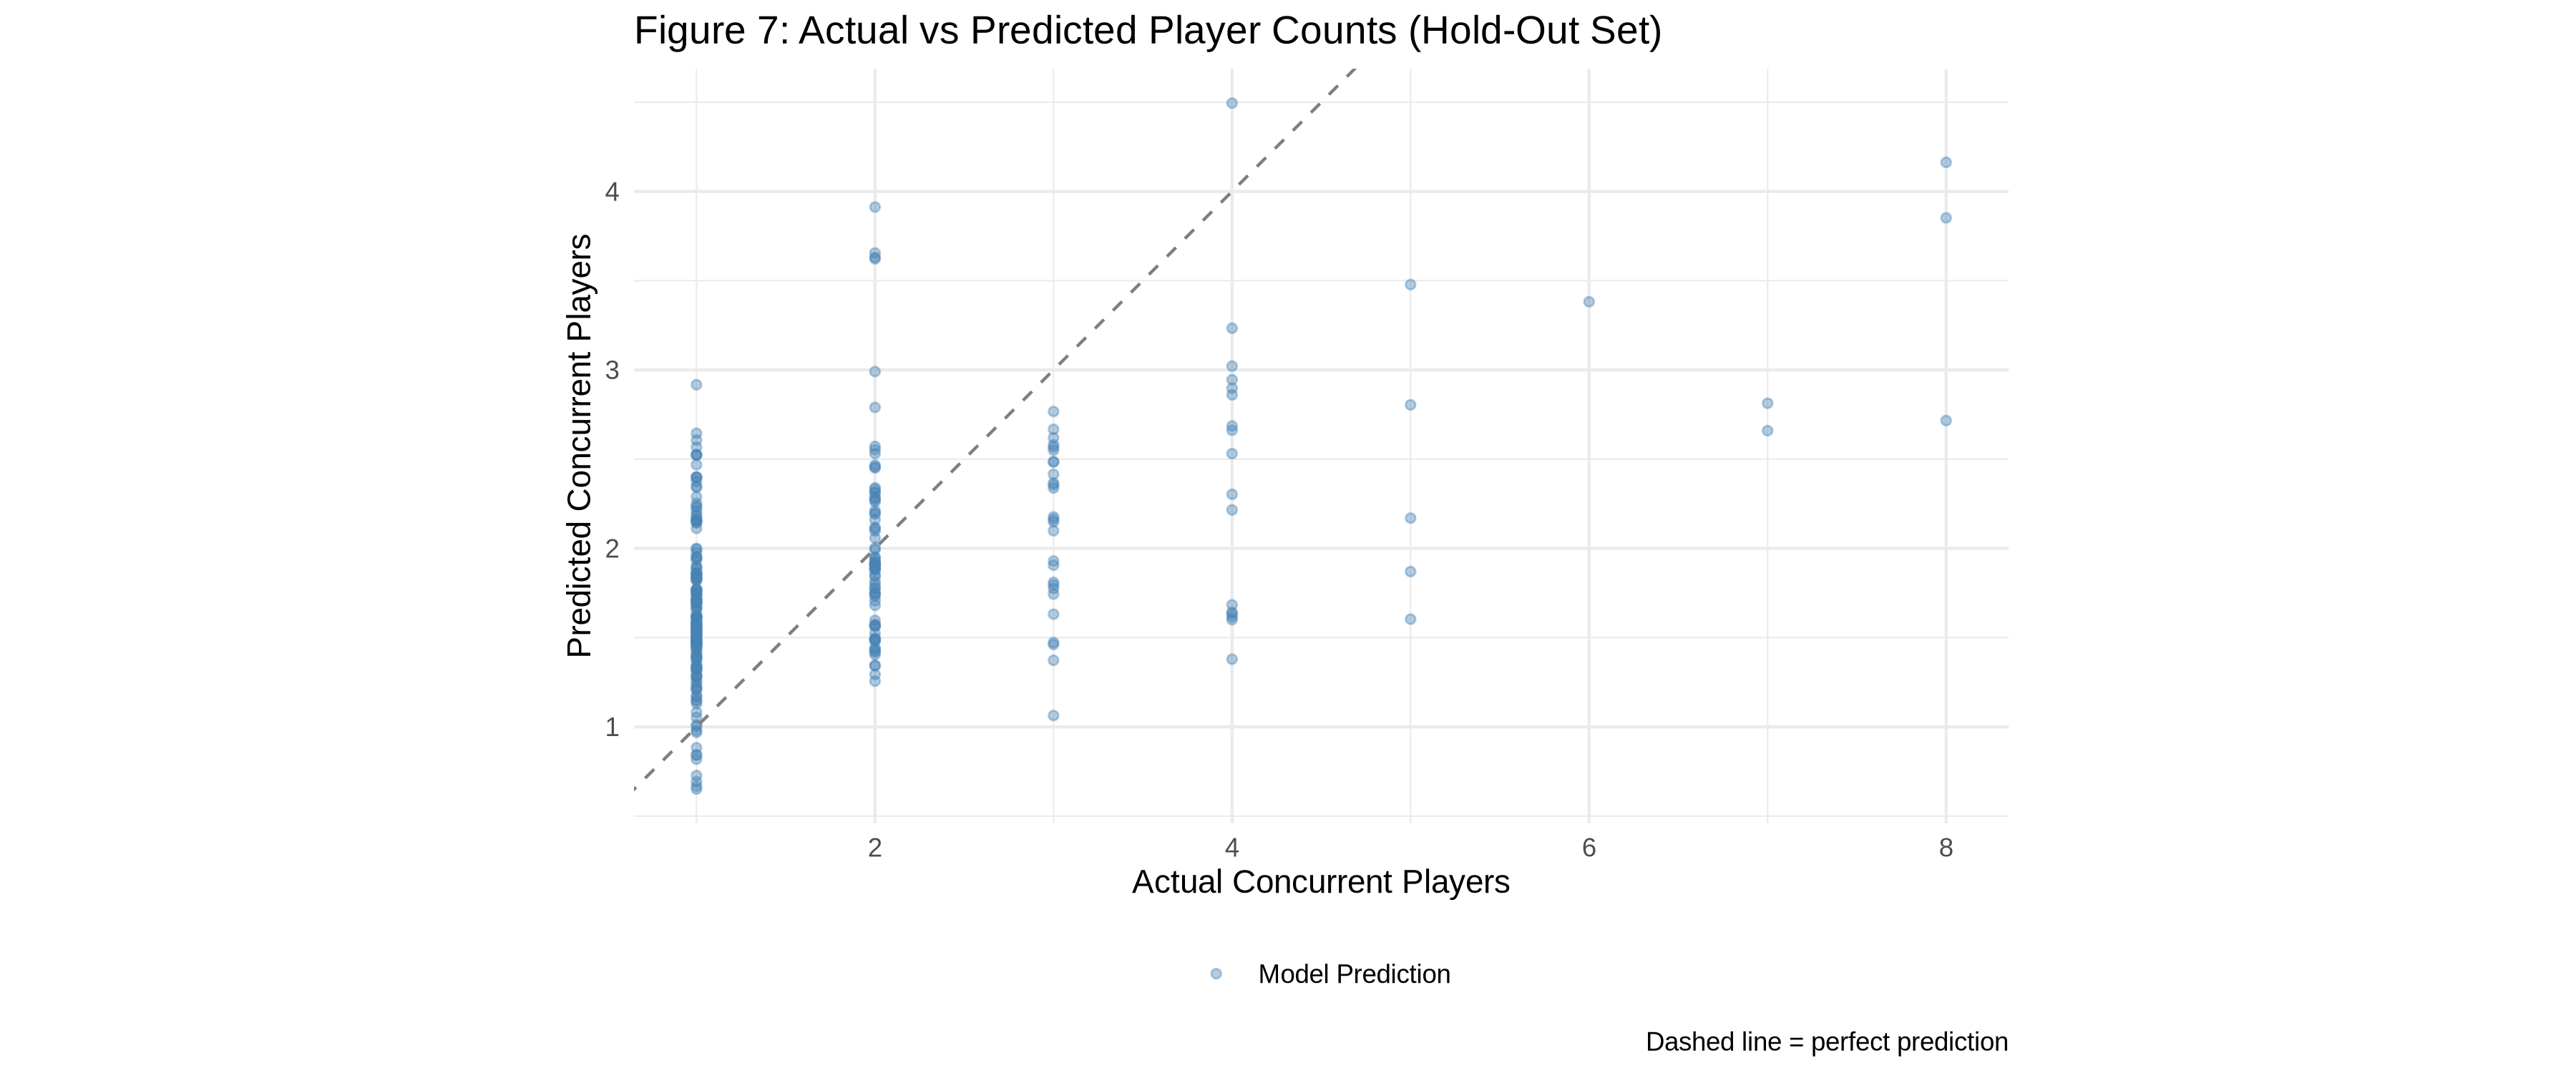

In [239]:
# Add label for legend
test_pred <- test_pred |>
  mutate(series = "Model Prediction")

# Plot with mapped color
ggplot(test_pred, aes(x = concurrent_players, y = .pred, colour = series)) +
  geom_point(alpha = 0.4, size = 1.2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", colour = "grey50") +
  scale_colour_manual(values = c("Model Prediction" = "steelblue")) +
  labs(
    title    = "Figure 7: Actual vs Predicted Player Counts (Hold-Out Set)",
    x        = "Actual Concurrent Players",
    y        = "Predicted Concurrent Players",
    caption  = "Dashed line = perfect prediction",
    colour   = NULL  
  ) +
  coord_equal() +
  theme_minimal() +
  theme(legend.position = "bottom")

## 6 Discussion


### What we found  
We built a model to predict how many players would be on a Minecraft server one hour into the future. It used simple inputs: how many people were online last hour (`lag1`) and the same hour yesterday (`lag24`). On test data the model hadn’t seen before, it predicted within about **0.78 players on average**. However, it only explained **about 27% of the variation** in player counts overall.

### Was this expected?  
We expected the number of players in the previous hour to be useful, and it was. But we thought yesterday’s data (`lag24`) would help more than it actually did. Most of the useful signal came from just the last hour, and the daily patterns were weaker than we expected.

### Why this matters  
Even with modest accuracy, a model like this can still be helpful. Knowing roughly how many players are about to join gives server operators a chance to spin up more capacity ahead of time. That can help avoid lag, improve the player experience, and save money by not running more servers than necessary.

### What’s next  
In the future, we could:

- Try predicting farther ahead (2–6 hours)
- Use more flexible models that can capture curves and outliers
- Include a measure of confidence with each prediction
- Test if this method works on different games or servers

### How we did it  
We used about five months of session data from Minecraft. After cleaning the data, we turned session times into hourly player counts, then used 80% of the data to train the model and 20% to test it. All steps were done in R using tidy, repeatable code.

We also created helpful features like previous-hour player counts (`lag1`), same-hour-yesterday counts (`lag24`), and time-based patterns (hour of day, day of week, etc.) to give the model more context.

Looking back, it might have been useful to train two separate models—one for `lag1` and one for `lag24`—rather than combining both into a single model. That way, we could better understand how each predictor performs on its own and whether they offer value in different situations (e.g., weekdays vs. weekends).

## 7 References

Forecasting: Principles and Practice (3rd ed). (n.d.). *2.7 Lag plots*. Retrieved June 23, 2025, from [https://otexts.com/fpp3/lag-plots.html](https://otexts.com/fpp3/lag-plots.html)

RStudio. (n.d.). *Dates and times with lubridate: Cheatsheet*. Retrieved June 23, 2025, from [https://rstudio.github.io/cheatsheets/html/lubridate.html?utm_source=chatgpt.com](https://rstudio.github.io/cheatsheets/html/lubridate.html?utm_source=chatgpt.com)

Grolemund, G., & Wickham, H. (n.d.-a). *2 Introduction*. In *R for data science*. Retrieved June 23, 2025, from [https://r4ds.had.co.nz/explore-intro.html](https://r4ds.had.co.nz/explore-intro.html)

Grolemund, G., & Wickham, H. (n.d.-b). *9 Introduction*. In *R for data science*. Retrieved June 23, 2025, from [https://r4ds.had.co.nz/wrangle-intro.html](https://r4ds.had.co.nz/wrangle-intro.html)

Grolemund, G., & Wickham, H. (n.d.-c). *Welcome*. In *R for data science*. Retrieved June 23, 2025, from [https://r4ds.had.co.nz/](https://r4ds.had.co.nz/)

## 8 Acknolweledgement
This project was heavily informed by techniques and best practices outlined in R for Data Science by Hadley Wickham and Garrett Grolemund (1st ed., 2017).